In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import json
import plotly.graph_objects as go

In [8]:
#Constants

R = 8.314
P = 1 #atm

A_but = 9.9614
B_but = 2664.0939
C_but = -104.881
A_h2O = 11.9647
B_h2O = 3984.9273
C_h2O = -39.734

g12_g22 = 1034.3
g21_g11 = 10098.50
aij = 0.4118

In [9]:
#Functions 

def molfrac_vapor(T, x):
    x_but = x
    x_h2O = 1 - x

    tau_12 = g12_g22 / (R * T)
    tau_21 = g21_g11 / (R * T)

    G_12 = np.exp(-aij * tau_12)
    G_21 = np.exp(-aij * tau_21)

    gamma_but = np.exp(x_h2O**2 * (tau_21 * (G_21 / (x_but + x_h2O * G_21))**2 + (tau_12 * G_12) / (x_h2O + x_but * G_12)**2))
    gamma_h2O = np.exp(x_but**2 * (tau_12 * (G_12 / (x_h2O + x_but * G_12))**2 + (tau_21 * G_21) / (x_but + x_h2O * G_21)**2))
    
    Psat_but = np.exp(A_but - B_but / (T + C_but))
    Psat_h2O = np.exp(A_h2O - B_h2O / (T + C_h2O))
    
    y_but = gamma_but * x_but * Psat_but / P
    y_h2O = gamma_h2O * x_h2O * Psat_h2O / P
    
    sum_y = y_but + y_h2O
    
    return sum_y - 1, y_but, y_h2O

def wrapper(T, x):
    sum_y, _, _ = molfrac_vapor(T, x)
    return sum_y

In [10]:
# Calculate the solutions for each x value
#x_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
x_values = np.arange(0.01, 1, 0.001)
solutions = {}  # Dictionary to store solutions
initial_guess = 373  # Kelvin

for i, x in enumerate(x_values):
    sol, = fsolve(wrapper, initial_guess, args=(x,))
    _, y_but, y_h2O = molfrac_vapor(sol, x)
    
    # Create a dictionary for this x value and store it in the solutions dictionary
    solutions[x] = {
        'Tsol': sol,
        'y_but': y_but,
        'y_h2O': y_h2O
    }

# Pretty-print the solutions dictionary
#print(json.dumps(solutions, indent=4))

# If you want to calculate the mean temperature
mean_T = np.mean([sol_dict['Tsol'] for sol_dict in solutions.values()])
print(f"Mean Tsol: {mean_T}")

Mean Tsol: 362.7038234664747


Text(0, 0.5, 'Fraction in vapor phase')

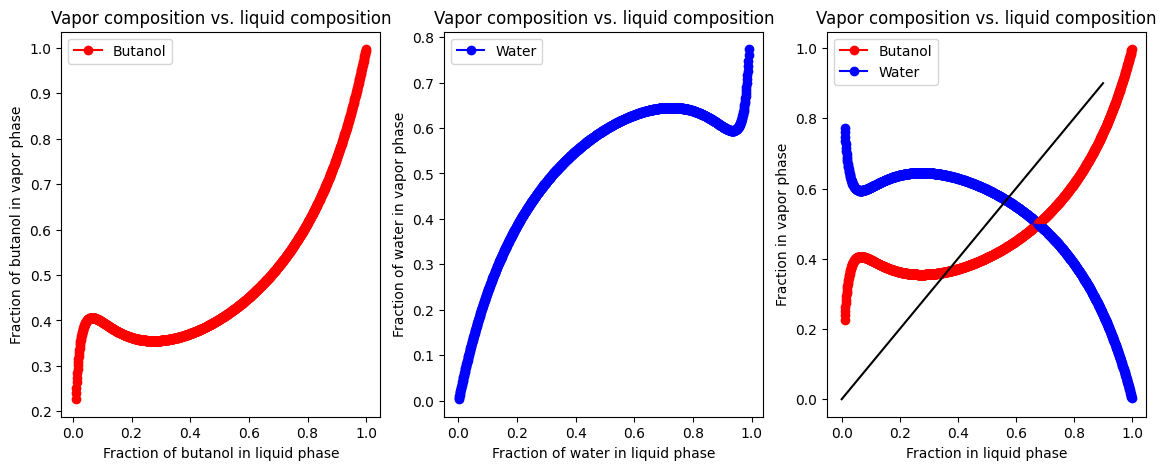

In [22]:
# Plot x vs y
fig, axs = plt.subplots(1,3, figsize=(14,5))
for x, sol_dict in solutions.items():
    axs[0].plot(x, sol_dict['y_but'], marker='o', color='red')
    axs[1].plot(1-x, sol_dict['y_h2O'], marker='o', color='blue')
    axs[2].plot(x, sol_dict['y_but'], marker='o', color='red')
    axs[2].plot(x, sol_dict['y_h2O'], marker='o', color='blue')

x_lin = np.arange(0,1, 0.1)
y_lin = np.arange(0,1, 0.1)

axs[0].plot(x_lin, y_lin, color='black')
axs[1].plot(x_lin, y_lin, color='black')
axs[2].plot(x_lin, y_lin, color='black')



axs[0].set_title('Vapor composition vs. liquid composition') 
axs[0].legend(['Butanol'])
axs[0].set_xlabel('Fraction of butanol in liquid phase')
axs[0].set_ylabel('Fraction of butanol in vapor phase')

axs[1].set_title('Vapor composition vs. liquid composition')
axs[1].legend(['Water'])
axs[1].set_xlabel('Fraction of water in liquid phase')
axs[1].set_ylabel('Fraction of water in vapor phase')

axs[2].set_title('Vapor composition vs. liquid composition')
axs[2].legend(['Butanol', 'Water'])
axs[2].set_xlabel('Fraction in liquid phase')
axs[2].set_ylabel('Fraction in vapor phase')






In [14]:
# 3D plot

x_values = [x for x in solutions.keys()]
x_values_h20 = [1-x for x in solutions.keys()]
y_but_values = [sol_dict['y_but'] for sol_dict in solutions.values()]
y_h2O_values = [sol_dict['y_h2O'] for sol_dict in solutions.values()]
Tsol_values = [sol_dict['Tsol'] for sol_dict in solutions.values()]

# Create the figure and add scatter plots
fig = go.Figure(data=[
    go.Scatter3d(x=x_values, y=y_but_values, z=Tsol_values, mode='markers',
                 marker=dict(size=6, color='red'), name='y_but'),
    go.Scatter3d(x=x_values_h20, y=y_h2O_values, z=Tsol_values, mode='markers',
                 marker=dict(size=6, color='blue'), name='y_h2O')
])

# Set labels, title, and figure size
fig.update_layout(
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='Tsol'),
    title='Vapor composition vs. Liquid composition vs. Temperature',
    width=800,  # Set the figure width
    height=600  # Set the figure height
)

# Show the plot
fig.show()
